In [5]:
import os

import cv2 as cv
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [6]:
def get_cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [7]:
classes_data = pd.read_csv(os.path.join("data", "class_list.txt"), sep=" ", header=None)
classes_data.columns = ["code", "label"]

In [8]:
def get_images_names(code):
    all_images = pd.read_csv(os.path.join(*["data", "raw", "train_info_dirty.csv"]), sep=",", header=None)
    all_images.columns = ["file_name", "class_code"]
    return all_images[all_images["class_code"] == code].file_name.to_list()

## Color Histograms

In [9]:
def get_ch_vectors(code, bins, image_name=None):
    if bins not in [8, 16, 32, 64, 128, 256]:
        raise Exception("Bins must be 8, 16, 32, 64, 128, or 256!")
    
    ch_path = os.path.join(*["data", "ch", str(code)])
    ch_class = pd.read_csv(os.path.join(ch_path, f"ch_{bins}.csv"), sep=";", header=0)
    ch_class["hist"] = ch_class["hist"].apply(lambda x: np.array(ast.literal_eval(x.replace('\n', '').replace('  ', ' ').strip())))
    
    # Return only one image ch
    if image_name is not None:
        return ch_class[ch_class["image_name"]==image_name]["hist"].item()
    
    # Return all images ch
    return ch_class

In [10]:
def show_hist(im_name: str, code, bins=256):

    # Create a GridSpec with 1 row and 2 columns, with different width ratios
    fig = plt.figure(figsize=(15, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3])
    
    # First subplot (image)
    ax1 = fig.add_subplot(gs[0])
    data_path = os.path.join("data", "clean", "train", str(code))
    im = cv.imread(os.path.join(data_path, im_name))
    im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    ax1.set_title(im_name)
    ax1.imshow(im)
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    # Second subplot (color hist)
    ax2 = fig.add_subplot(gs[1])
    ax2.set_xlim([-1, bins*3+1])
    ax2.set_xticks([])
    
    ch = get_ch_vectors(code, bins, image_name=im_name)
    
    ind = np.arange(len(ch))  
    
    red = ch[0:bins]
    ax2.plot(ind[0:bins], red, color="r")
    ax2.axvline(x=bins, color="black", ls=":", lw=0.2)
    
    green = ch[bins:bins * 2]
    ax2.plot(ind[bins:bins * 2], green, color="g") 
    ax2.axvline(x=(bins * 2), color="black", ls=":", lw=0.2)
    
    blue = ch[bins * 2:bins * 3]
    ax2.plot(ind[bins * 2:bins * 3], blue, color="b")
    ax2.set_title(f"Color Histogram, bins={bins}")
    
    # Overall title for the figure
    plt.suptitle(f"Sample of Class {classes_data[classes_data.code == code].label.item()}", fontweight="bold")
    
    # Display the plot
    plt.show()

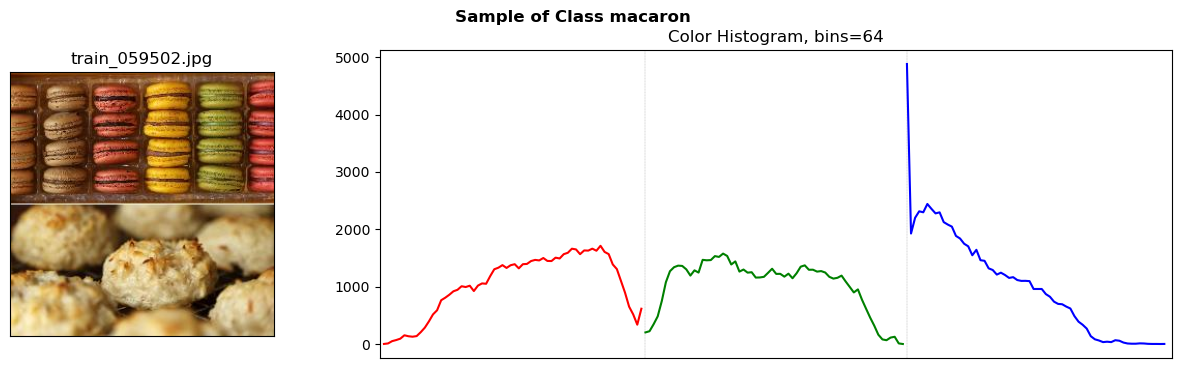

In [11]:
class_code = 0
for name in np.random.choice(get_images_names(0), size=1):
    show_hist(name, class_code, bins=64)

### Cosine Similarity

In [12]:
def show_lf_five_ch(code, bins):
    # Get ch vectors 
    ch = get_ch_vectors(code, bins)
    ch_images_names = ch["image_name"].to_list()
    ch_vectors = ch["hist"].to_list()
    
    # Calculate similarities
    all_similarities = []
    for i in ch_vectors:
        image_similarities = []
        for j in ch_vectors:
            image_similarities.append(get_cosine_similarity(i, j))
        all_similarities.append(np.sum(image_similarities))
    class_similarities = pd.DataFrame({
        "image_name": ch_images_names,
        "sim_sum": all_similarities
    }).sort_values(by="sim_sum", ascending=False)
    
    # Plot images (last 5 and first 5)
    last_five = class_similarities.tail(5)["image_name"].to_list()
    first_five = class_similarities.head(5)["image_name"].to_list()
    to_plot = last_five + first_five
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    row_titles = ["Least Similar", "Most Similar"]
    
    for i, ax in enumerate(axes.flat):
        temp_im = os.path.join(*["data", "clean", "train", str(code), to_plot[i]])
        im = cv.imread(temp_im)
        im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
        ax.imshow(im)
        ax.axis("off")
    
    for i, ax in enumerate(axes[:, 0]):
        ax.set_title(row_titles[i], loc='left', fontsize=16, weight='bold')
    
    plt.suptitle(
        f"Class {classes_data[classes_data.code == code].label.item()}, Bins {bins}", 
        fontsize=20, 
        weight='bold'
    )
    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.show() 

In [ ]:

    classes_to_label = [
        196, 15,
        0, 233,
        57, 25
    ]

    classes_names = [
        "omelette", "seaweed salad",
        "macaron", "scotch egg",
        "gnocchi", "ramen"
    ]


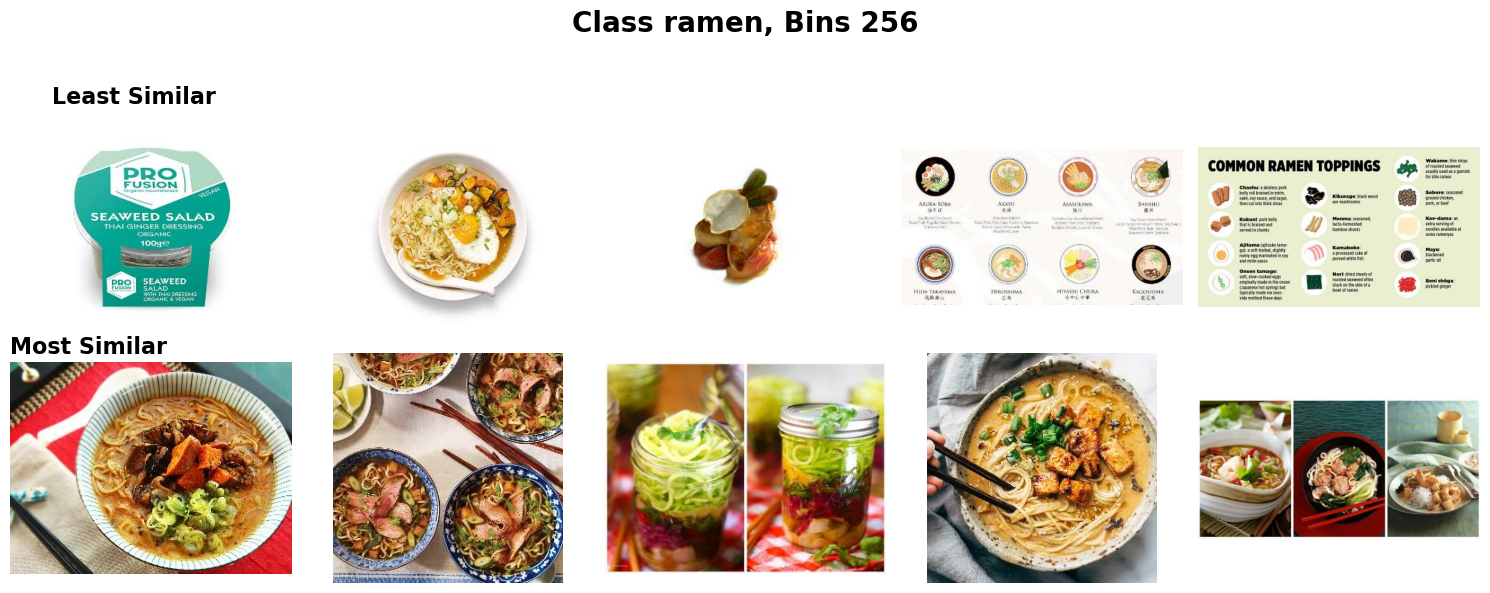

In [18]:
# 196 omelette
# 15 seaweed salad
show_lf_five_ch(25, 256)

## BOVW

In [19]:
def get_bovw_vectors(code, dim, image_name=None):
    if dim not in [10, 20, 40, 80]:
        print("Dim must be 10, 20, 40, or 80!")
        raise Exception("Wrong Parameter Value")

    bovw_path = os.path.join(*["data", "bovw", str(code)])
    bovw_class = pd.read_csv(os.path.join(bovw_path, f"tfidf_{dim}.csv"), sep=";", header=0)
    bovw_class["tfidf"] = bovw_class["tfidf"].apply(
        lambda x: np.array(ast.literal_eval(x.replace('\n', '').replace('  ', ' ').strip())))

    # Return only one image bovw
    if image_name is not None:
        return bovw_class[bovw_class["image_name"] == image_name]["tfidf"].item()

    # Return all images bovw
    return bovw_class

In [20]:
def show_lf_five_bovw(code, dim):
    # Get ch vectors 
    bovw = get_bovw_vectors(code, dim)
    bovw_images_names = bovw["image_name"].to_list()
    tfidf_vectors = bovw["tfidf"].to_list()
    
    # Calculate similarities
    all_similarities = []
    for i in tfidf_vectors:
        image_similarities = []
        for j in tfidf_vectors:
            image_similarities.append(get_cosine_similarity(i, j))
        all_similarities.append(np.sum(image_similarities))
    class_similarities = pd.DataFrame({
        "image_name": bovw_images_names,
        "sim_sum": all_similarities
    }).sort_values(by="sim_sum", ascending=False)
    
    # Plot images (last 5 and first 5)
    last_five = class_similarities.tail(5)["image_name"].to_list()
    first_five = class_similarities.head(5)["image_name"].to_list()
    to_plot = last_five + first_five
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    row_titles = ["Least Similar", "Most Similar"]
    
    for i, ax in enumerate(axes.flat):
        temp_im = os.path.join(*["data", "clean", "train", str(code), to_plot[i]])
        im = cv.imread(temp_im)
        im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
        ax.imshow(im)
        ax.axis("off")
    
    for i, ax in enumerate(axes[:, 0]):
        ax.set_title(row_titles[i], loc='left', fontsize=16, weight='bold')
    
    plt.suptitle(
        f"Class {classes_data[classes_data.code == code].label.item()}, Dim {dim}", 
        fontsize=20, 
        weight='bold'
    )
    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.show()

In [21]:
def plot_images_in_grid(images, code, cols=3):
    # Calculate rows needed
    rows = int(np.ceil(len(images) / cols))
    
    # Create a figure to contain the grid of images
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    
    for i, img_path in enumerate(images):
        # Open the image
        temp_im = os.path.join(*["data", "clean", "train", str(code), img_path])
        img = cv.imread(temp_im)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        
        # Find the correct axis
        ax = axes[i // cols, i % cols]
        
        # Plot the image
        ax.imshow(img)
        ax.axis('off')  # Hide the axes
        
    # Hide any remaining empty subplots
    for j in range(i + 1, rows * cols):
        fig.delaxes(axes[j // cols, j % cols])
    
    plt.tight_layout()
    plt.show()

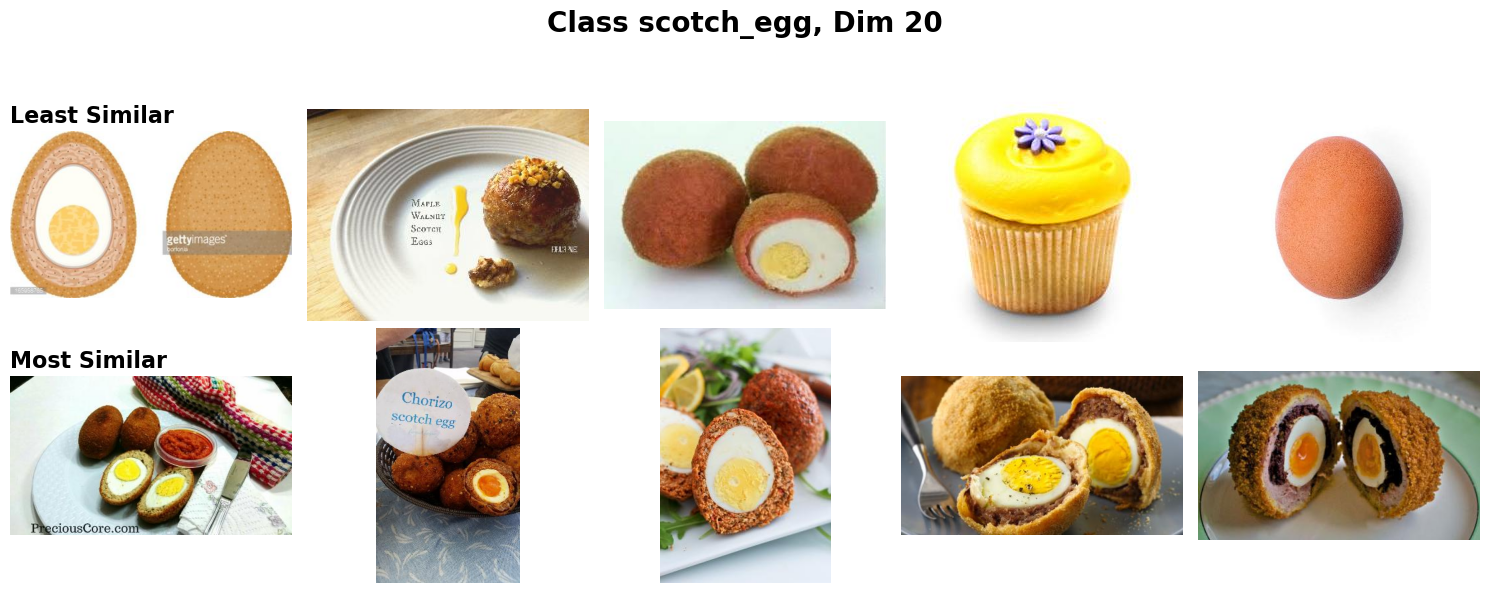

In [25]:
# 0 macaron
# 233 scotch egg
show_lf_five_bovw(233, 20)

## Features Extraction using ViT trained on Food101

In [26]:
def get_fe_vectors(code, image_name=None):
    fe_path = os.path.join(*["data", "fe", str(code)])
    fe_class = pd.read_csv(os.path.join(fe_path, f"vit.csv"), sep=";", header=0)
    fe_class["vit_feature"] = fe_class["vit_feature"].apply(
        lambda x: np.array(ast.literal_eval(x.replace('\n', '').replace('  ', ' ').strip())))

    # Return only one image bovw
    if image_name is not None:
        return fe_class[fe_class["image_name"] == image_name]["vit_feature"].item()

    # Return all images bovw
    return fe_class

In [27]:
def show_lf_five_fe(code):
    # Get ch vectors 
    fe_data = get_fe_vectors(code)
    fe_images_names = fe_data["image_name"].to_list()
    fe_vectors = fe_data["vit_feature"].to_list()
    
    # Calculate similarities
    all_similarities = []
    for i in fe_vectors:
        image_similarities = []
        for j in fe_vectors:
            image_similarities.append(get_cosine_similarity(i, j))
        all_similarities.append(np.sum(image_similarities))
    class_similarities = pd.DataFrame({
        "image_name": fe_images_names,
        "sim_sum": all_similarities
    }).sort_values(by="sim_sum", ascending=False)
    
    # Plot images (last 5 and first 5)
    last_five = class_similarities.tail(5)["image_name"].to_list()
    first_five = class_similarities.head(5)["image_name"].to_list()
    to_plot = last_five + first_five
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    row_titles = ["Least Similar", "Most Similar"]
    
    for i, ax in enumerate(axes.flat):
        temp_im = os.path.join(*["data", "clean", "train", str(code), to_plot[i]])
        im = cv.imread(temp_im)
        im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
        ax.imshow(im)
        ax.axis("off")
    
    for i, ax in enumerate(axes[:, 0]):
        ax.set_title(row_titles[i], loc='left', fontsize=16, weight='bold')
    
    plt.suptitle(
        f"Class {classes_data[classes_data.code == code].label.item()}", 
        fontsize=20, 
        weight='bold'
    )
    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.show()
    
    return class_similarities

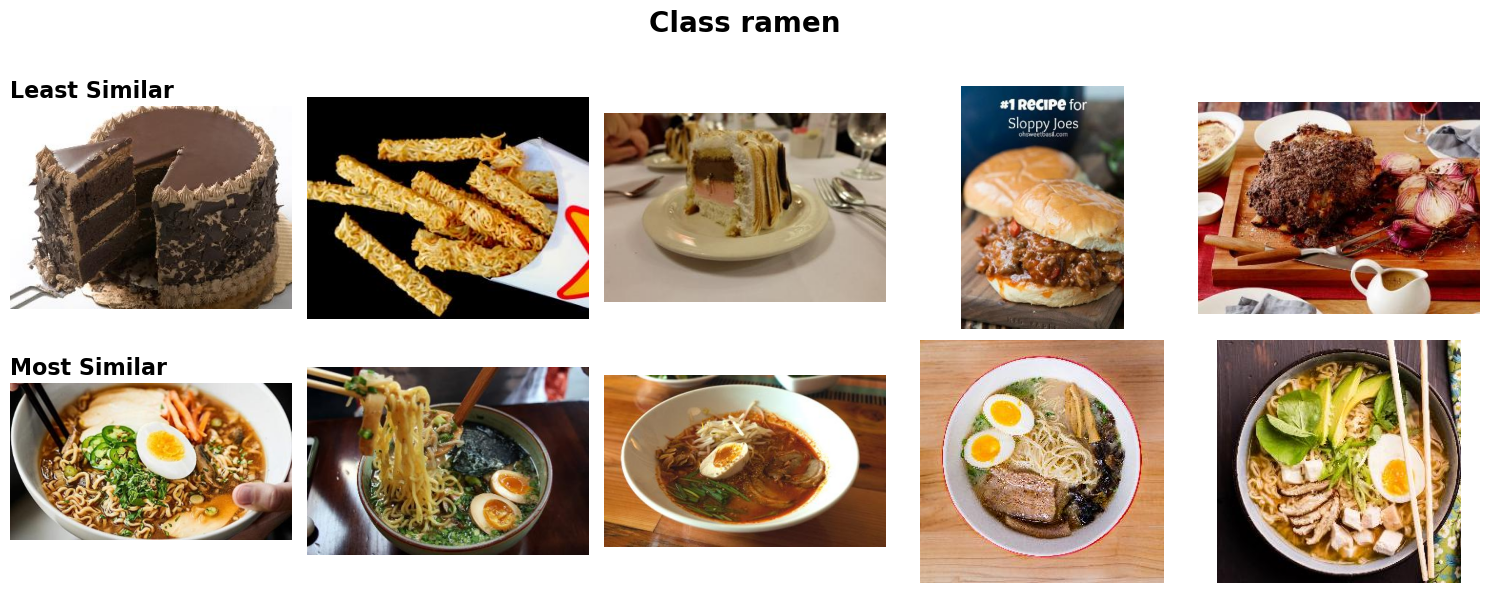

In [30]:
# 57 gnocchi
# 25 ramen
class_sim = show_lf_five_fe(25)